In [1]:
import sys
sys.path.append('../..')
from utilities.get_data import get_historical_from_db
from utilities.backtesting import plot_wallet_vs_asset, get_metrics, get_n_columns, basic_multi_asset_backtest, plot_sharpe_evolution, plot_bar_by_month
from utilities.custom_indicators import SuperTrend
from utilities.futur_simulations import plot_futur_simulations, plot_train_test_simulation
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import ccxt
import matplotlib.pyplot as plt
import ta
import numpy as np

In [2]:

class super_reversion_strat():
    def __init__(
        self,
        df_list,
        oldest_pair,
        parameters_obj,
        type=["long"],
    ):
        self.df_list = df_list
        self.oldest_pair = oldest_pair
        self.parameters_obj = parameters_obj
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        
    def populate_indicators(self, show_log=False):
        # -- Clear dataset --
        for pair in self.df_list:
            df = self.df_list[pair]
            params = self.parameters_obj[pair]
            df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)
            
            # -- Populate indicators --
            super_trend = SuperTrend(
                df['high'], 
                df['low'], 
                df['close'], 
                params["st_short_atr_window"], 
                params["st_short_atr_multiplier"]
            )
            
            df['super_trend_direction'] = super_trend.super_trend_direction()
            df['ema_short'] = ta.trend.ema_indicator(close=df['close'], window=params["short_ema_window"])
            df['ema_long'] = ta.trend.ema_indicator(close=df['close'], window=params["long_ema_window"])
            
            df = get_n_columns(df, ["super_trend_direction", "ema_short", "ema_long"], 1)
            
            self.df_list[pair] = df
            # -- Log --
            if(show_log):
                print(self.df_list[self.oldest_pair])
                
        return self.df_list[self.oldest_pair]
    
    def populate_buy_sell(self, show_log=False): 
        data_open_long = []
        data_close_long = []
        data_open_short = []
        data_close_short = []

        for pair in self.df_list:
            params = self.parameters_obj[pair]
            df = self.df_list[pair]
            # -- Initiate populate --
            df["open_long_limit"] = False
            df["close_long_limit"] = False
            df["open_short_limit"] = False
            df["close_short_limit"] = False
            df["pair"] = pair
            df["null"] = np.nan
            
            if self.use_long:
                # -- Populate open long limit --
                df.loc[
                    (df['n1_ema_short'] >= df['n1_ema_long']) 
                    & (df['n1_super_trend_direction'] == True) 
                    & (df['n1_ema_short'] > df['low']) 
                    , "open_long_limit"
                ] = True
                
                # -- Populate close long limit --
                df.loc[
                    ((df['n1_ema_short'] <= df['n1_ema_long'])
                    | (df['n1_super_trend_direction'] == False))
                    & (df['n1_ema_short'] < df['high'])
                    , "close_long_limit"
                ] = True

            if self.use_short:
                # -- Populate open short limit --
                df.loc[
                    (df['n1_ema_short'] <= df['n1_ema_long']) 
                    & (df['n1_super_trend_direction'] == False) 
                    & (df['n1_ema_short'] < df['high']) 
                    , "open_short_limit"
                ] = True
                
                # -- Populate close short market --
                df.loc[
                    ((df['n1_ema_short'] >= df['n1_ema_long']) 
                    | (df['n1_super_trend_direction'] == True))
                    & (df['n1_ema_short'] > df['low']) 
                    , "close_short_limit"
                ] = True
                
            # -- Populate pair list per date (do not touch)--
            data_open_long.append(
                df.loc[
                (df['open_long_limit']  == True) 
                ]['pair']
            )
            data_close_long.append(
                df.loc[
                (df['close_long_limit']  == True) 
                ]['pair']
            )
            data_open_short.append(
                df.loc[
                (df['open_short_limit']  == True) 
                ]['pair']
            )
            data_close_short.append(
                df.loc[
                (df['close_short_limit']  == True) 
                ]['pair']
            )

        data_open_long.append(self.df_list[self.oldest_pair]['null'])
        data_close_long.append(self.df_list[self.oldest_pair]['null'])
        data_open_short.append(self.df_list[self.oldest_pair]['null'])
        data_close_short.append(self.df_list[self.oldest_pair]['null'])
        df_open_long = pd.concat(data_open_long, axis=1)
        df_open_long['combined']= df_open_long.values.tolist()
        df_open_long['combined'] = [[i for i in j if i == i] for j in list(df_open_long['combined'])]
        df_close_long = pd.concat(data_close_long, axis=1)
        df_close_long['combined']= df_close_long.values.tolist()
        df_close_long['combined'] = [[i for i in j if i == i] for j in list(df_close_long['combined'])]
        df_open_short = pd.concat(data_open_short, axis=1)
        df_open_short['combined']= df_open_short.values.tolist()
        df_open_short['combined'] = [[i for i in j if i == i] for j in list(df_open_short['combined'])]
        df_close_short = pd.concat(data_close_short, axis=1)
        df_close_short['combined']= df_close_short.values.tolist()
        df_close_short['combined'] = [[i for i in j if i == i] for j in list(df_close_short['combined'])]
        self.open_long_obj = df_open_long['combined']
        self.close_long_obj = df_close_long['combined']
        self.open_short_obj = df_open_short['combined']
        self.close_short_obj = df_close_short['combined']
        
        # -- Log --
        if(show_log):
            print("Open LONG length on oldest pair :",len(self.df_list[self.oldest_pair].loc[self.df_list[self.oldest_pair]["open_long_limit"]==True]))
            print("Close LONG length on oldest pair :",len(self.df_list[self.oldest_pair].loc[self.df_list[self.oldest_pair]["close_long_limit"]==True]))
            print("Open SHORT length on oldest pair :",len(self.df_list[self.oldest_pair].loc[self.df_list[self.oldest_pair]["open_short_limit"]==True]))
            print("Close SHORT length on oldest pair :",len(self.df_list[self.oldest_pair].loc[self.df_list[self.oldest_pair]["close_short_limit"]==True]))
        
        return self.df_list[self.oldest_pair]
    
    def run_backtest(self, initial_wallet=1000, return_type="metrics"):
        df_ini = self.df_list[self.oldest_pair][:]
        wallet = initial_wallet
        usd_remaining = initial_wallet
        usd_pct_remaining = 1
        maker_fee = 0
        taker_fee = 0.0007
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_positions = {}
        
        for index, row in df_ini.iterrows():
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                for pos in current_positions:
                    actual_row = self.df_list[pos].loc[index]
                    if current_positions[pos]['side'] == "LONG":
                        close_price = actual_row['close']
                        trade_result = (close_price - current_positions[pos]['price']) / current_positions[pos]['price']
                        close_size = current_positions[pos]['size'] + current_positions[pos]['size']  * trade_result
                        fee = close_size * taker_fee
                        temp_wallet += close_size - current_positions[pos]['size'] - fee
                    elif current_positions[pos]['side'] == "SHORT":
                        close_price = actual_row['close']
                        trade_result = (current_positions[pos]['price'] - close_price) / current_positions[pos]['price']
                        close_size = current_positions[pos]['size'] + current_positions[pos]['size']  * trade_result
                        fee = close_size * taker_fee
                        temp_wallet += close_size - current_positions[pos]['size'] - fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day 
            
            # Sell
            close_long_row = self.close_long_obj.loc[index]
            close_short_row = self.close_short_obj.loc[index]
            if len(current_positions) > 0:
                position_to_close = set({k: v for k,v in current_positions.items() if v['side'] == "LONG"}).intersection(set(close_long_row))
                for pos in position_to_close:
                    actual_row = self.df_list[pos].loc[index]
                    close_price = actual_row['n1_ema_short']
                    trade_result = (close_price - current_positions[pos]['price']) / current_positions[pos]['price']
                    close_size = current_positions[pos]['size'] + current_positions[pos]['size']  * trade_result
                    fee = close_size * maker_fee
                    wallet += close_size - current_positions[pos]['size'] - fee
                    usd_remaining += close_size - fee
                    usd_pct_remaining += self.parameters_obj[pos]['wallet_exposure']
                    trades.append({
                        "pair": pos,
                        "open_date": current_positions[pos]['date'],
                        "close_date": index,
                        "position": current_positions[pos]['side'],
                        "open_reason": current_positions[pos]['reason'],
                        "close_reason": "Limit",
                        "open_price": current_positions[pos]['price'],
                        "close_price": close_price,
                        "open_fee": current_positions[pos]['fee'],
                        "close_fee": fee,
                        "open_trade_size":current_positions[pos]['size'],
                        "close_trade_size":close_size,
                        "wallet": wallet,
                        "usd_remaining": usd_remaining
                    })
                    del current_positions[pos]   
                short_position_to_close = set({k: v for k,v in current_positions.items() if v['side'] == "SHORT"}).intersection(set(close_short_row))
                for pos in short_position_to_close:
                    actual_row = self.df_list[pos].loc[index]
                    close_price = actual_row['ema_short']
                    trade_result = (current_positions[pos]['price'] - close_price) / current_positions[pos]['price']
                    close_size = current_positions[pos]['size'] + current_positions[pos]['size'] * trade_result
                    fee = close_size * maker_fee
                    wallet += close_size - current_positions[pos]['size'] - fee
                    usd_remaining += close_size - fee
                    usd_pct_remaining += self.parameters_obj[pos]['wallet_exposure']
                    trades.append({
                        "pair": pos,
                        "open_date": current_positions[pos]['date'],
                        "close_date": index,
                        "position": current_positions[pos]['side'],
                        "open_reason": current_positions[pos]['reason'],
                        "close_reason": "Limit",
                        "open_price": current_positions[pos]['price'],
                        "close_price": close_price,
                        "open_fee": current_positions[pos]['fee'],
                        "close_fee": fee,
                        "open_trade_size":current_positions[pos]['size'],
                        "close_trade_size":close_size,
                        "wallet": wallet,
                        "usd_remaining": usd_remaining
                    })
                    del current_positions[pos] 
                    
            # Buy
            open_long_row = self.open_long_obj.loc[index]
            if len(open_long_row) > 0:
                for pos in open_long_row:
                    if pos not in current_positions:
                        actual_row = self.df_list[pos].loc[index]
                        open_price = actual_row['n1_ema_short']
                        pos_size = usd_remaining * (self.parameters_obj[pos]['wallet_exposure'] / usd_pct_remaining)
                        usd_pct_remaining -= self.parameters_obj[pos]['wallet_exposure']
                        fee = pos_size * maker_fee
                        pos_size -= fee
                        wallet -= fee
                        usd_remaining -= pos_size+fee
                        current_positions[pos] = {
                            "size": pos_size,
                            "date": index,
                            "price": open_price,
                            "fee":fee,
                            "reason": "Limit",
                            "side": "LONG"
                        }
            open_short_row = self.open_short_obj.loc[index]
            if len(open_short_row) > 0:
                for pos in open_short_row:
                    if pos not in current_positions:
                        actual_row = self.df_list[pos].loc[index]
                        open_price = actual_row['n1_ema_short']
                        pos_size = usd_remaining * (self.parameters_obj[pos]['wallet_exposure'] / usd_pct_remaining)
                        usd_pct_remaining -= self.parameters_obj[pos]['wallet_exposure']
                        fee = pos_size * maker_fee
                        pos_size -= fee
                        wallet -= fee
                        usd_remaining -= pos_size+fee
                        current_positions[pos] = {
                            "size": pos_size,
                            "date": index,
                            "price": open_price,
                            "fee":fee,
                            "reason": "Limit",
                            "side": "SHORT"
                        }
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
        df_trades = df_trades.set_index(df_trades['open_date'])   
        
        if return_type == "metrics":
            return get_metrics(df_trades, df_days) | {
                "wallet": wallet,
                "trades": df_trades,
                "days": df_days
            }  
        else:
            return True

In [3]:
params_coin = {
    "BTC/USDT": {
        "wallet_exposure": 0.3,
        "st_short_atr_window": 15,
        "st_short_atr_multiplier": 5,
        "short_ema_window": 20,
        "long_ema_window": 400
    },
    "ETH/USDT": {
        "wallet_exposure": 0.1,
        "st_short_atr_window": 15,
        "st_short_atr_multiplier": 5,
        "short_ema_window": 40,
        "long_ema_window": 400
    },
    "LTC/USDT": {
        "wallet_exposure": 0.2,
        "st_short_atr_window": 15,
        "st_short_atr_multiplier": 5,
        "short_ema_window": 5,
        "long_ema_window": 400
    },
    "SOL/USDT": {
        "wallet_exposure": 0.2,
        "st_short_atr_window": 15,
        "st_short_atr_multiplier": 5,
        "short_ema_window": 40,
        "long_ema_window": 400
    },
    "BNB/USDT": {
        "wallet_exposure": 0.2,
        "st_short_atr_window": 15,
        "st_short_atr_multiplier": 5,
        "short_ema_window": 20,
        "long_ema_window": 400
    },
}

pair_list = list(params_coin.keys())
tf = '1h'
oldest_pair = "BTC/USDT"

df_list = {}
for pair in pair_list:
    df = get_historical_from_db(ccxt.binance(), pair, tf, path="../../database/")
    df_list[pair] = df.loc[:]

print("Data load 100%")
df_list[oldest_pair]

Data load 100%


,open,high,low,close,volume
date,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2022-12-16 15:00:00,17030.34,17032.16,16910.13,16972.34,10787.721970
2022-12-16 16:00:00,16972.33,16979.02,16732.36,16811.67,21297.537180
2022-12-16 17:00:00,16810.64,16837.97,16757.30,16796.29,11694.021790


Period: [2017-08-17 00:00:00] -> [2022-12-16 00:00:00]
Initial wallet: 1000.0
Trades on 5 pairs

--- General Information
Final wallet: 96870.52
Performance vs US dollar: 9587.05 %
Sharpe Ratio: 1.9
Worst Drawdown T|D: -31.98% | -33.88%
Buy and hold performance: 304.46 %
Performance vs buy and hold: 2295.06 %
Total trades on the period: 1508
Global Win rate: 34.95 %
Average Profit: 1.99 %

----- Pair Result--
-----------------------------------------------------------------------------------------------
Trades      Pair     Sum-result     Mean-trade    Worst-trade     Best-trade       Win-rate
-----------------------------------------------------------------------------------------------
319     BTC/USDT       394.96 %         1.24 %        -27.8 %        44.78 %        34.48 %
296     ETH/USDT       595.85 %         2.01 %       -19.44 %        86.18 %        36.82 %
319     BNB/USDT       982.28 %         3.08 %       -24.51 %       441.76 %         39.5 %
439     LTC/USDT       457.1

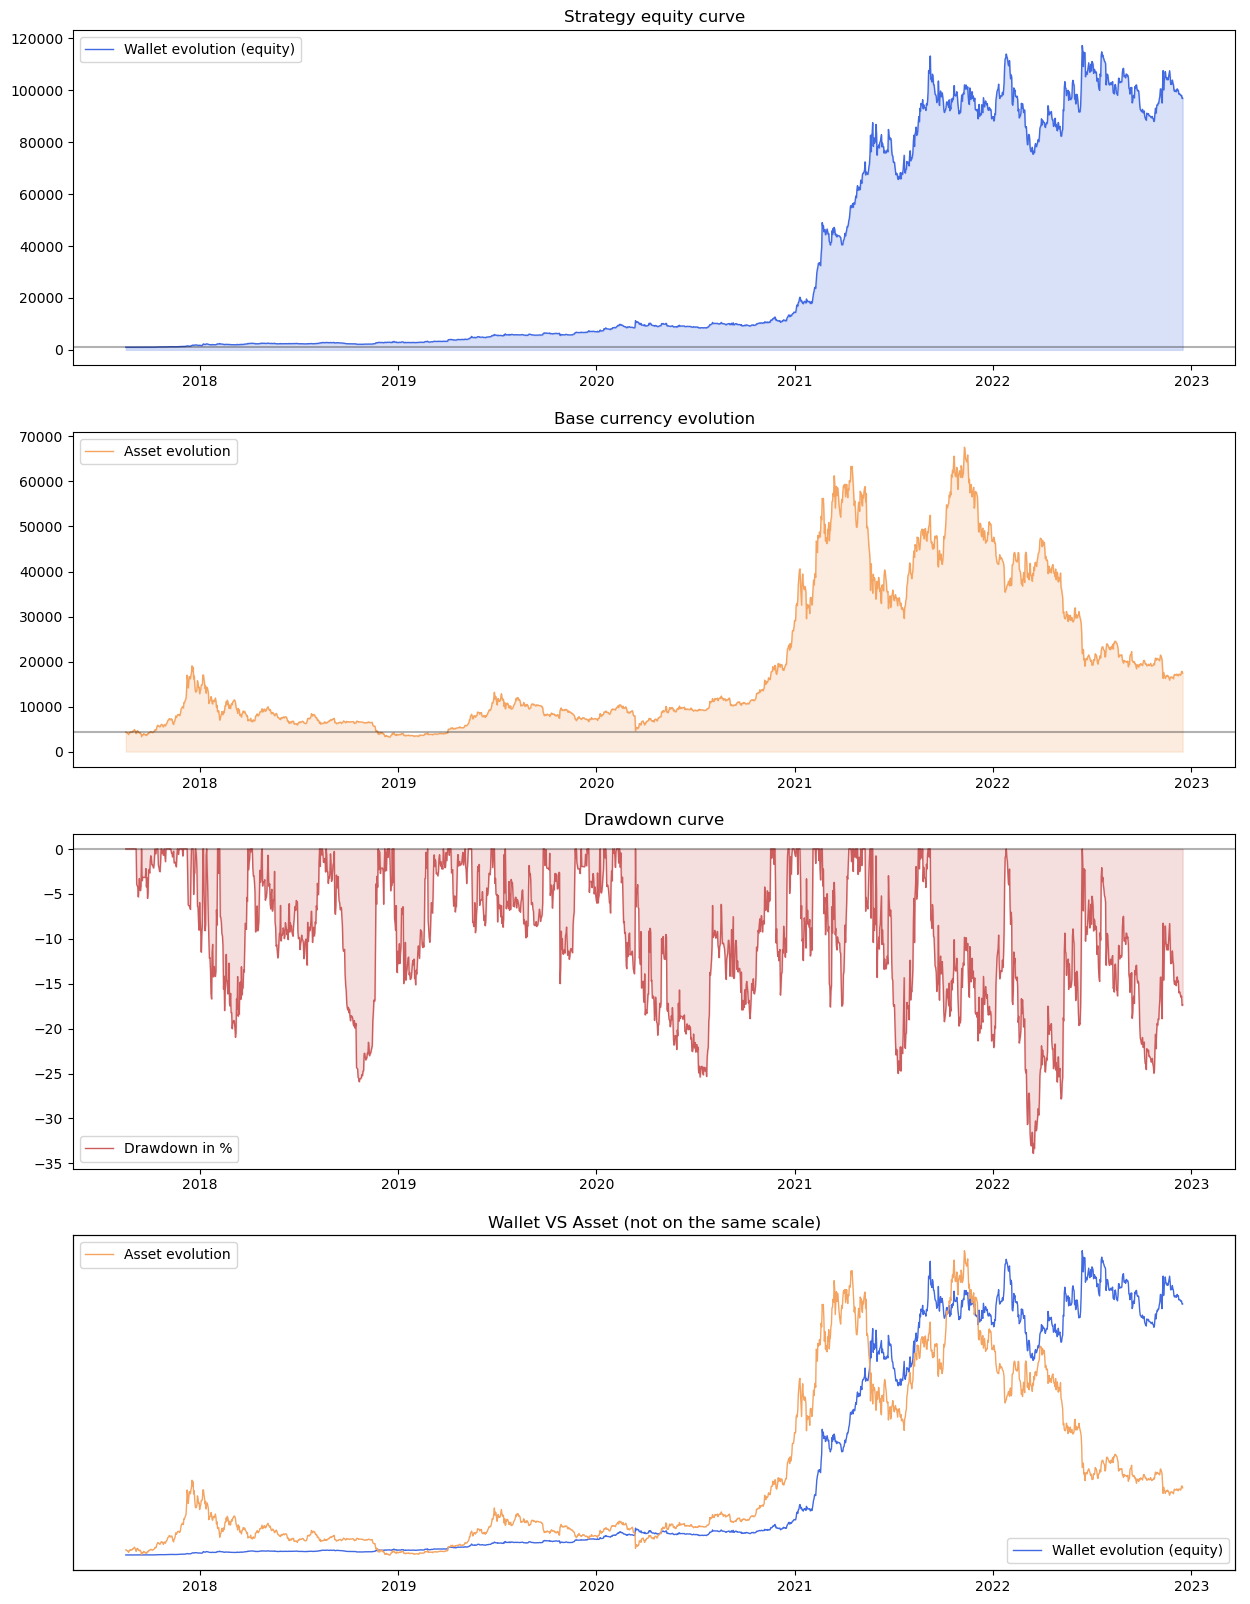

In [4]:
strat = super_reversion_strat(
    df_list=df_list,
    oldest_pair=oldest_pair,
    parameters_obj=params_coin,
    type=["long","short"]
)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, return_type="metrics")

df_trades, df_days = basic_multi_asset_backtest(trades=bt_result['trades'], days = bt_result['days'])
plot_wallet_vs_asset(df_days=df_days)

In [5]:
df_trades["trade_result_pct_wallet"].std()

0.020976590866941022

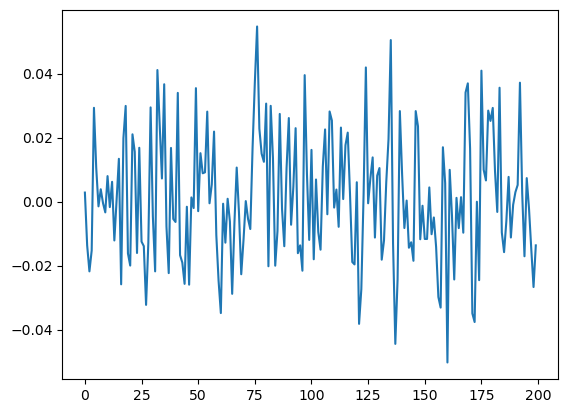

In [6]:
plt.plot(np.random.normal(0, 0.02, 200))

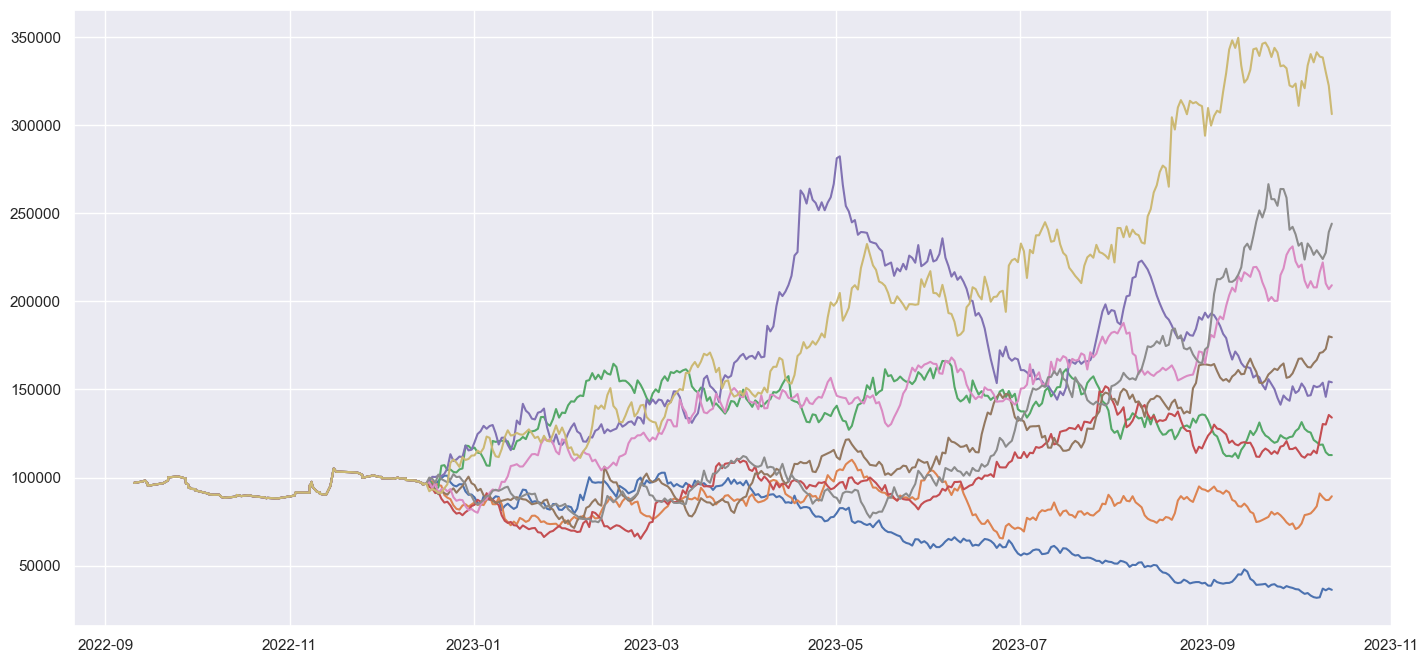

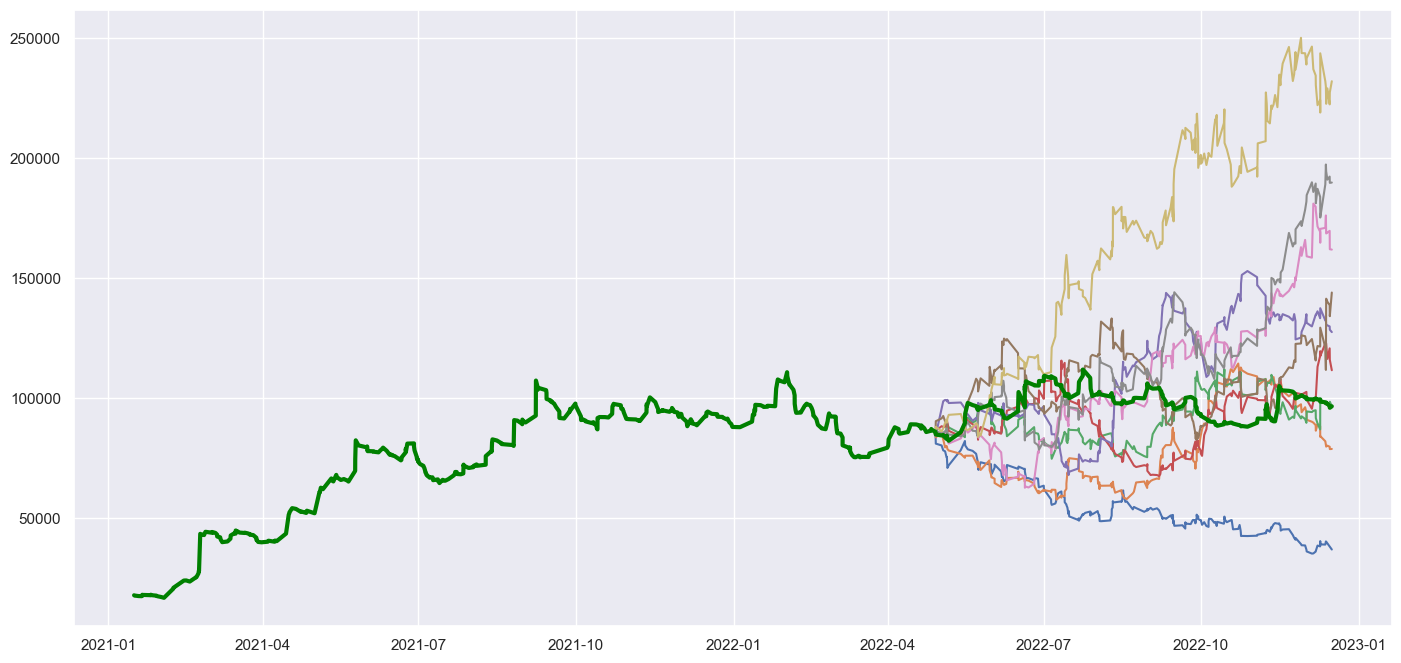

In [18]:
plot_futur_simulations(
    df_trades=df_trades,
    trades_multiplier=3,
    trades_to_forecast=300,
    number_of_simulations=1000,
    true_trades_to_show=100,
    show_all_simulations=False
)
plot_train_test_simulation(
    df_trades=df_trades,
    train_test_date="2022-04-29",
    trades_multiplier=3,
    number_of_simulations=1000,
)

----- 2017 Cumulative Performances: 77.51%--


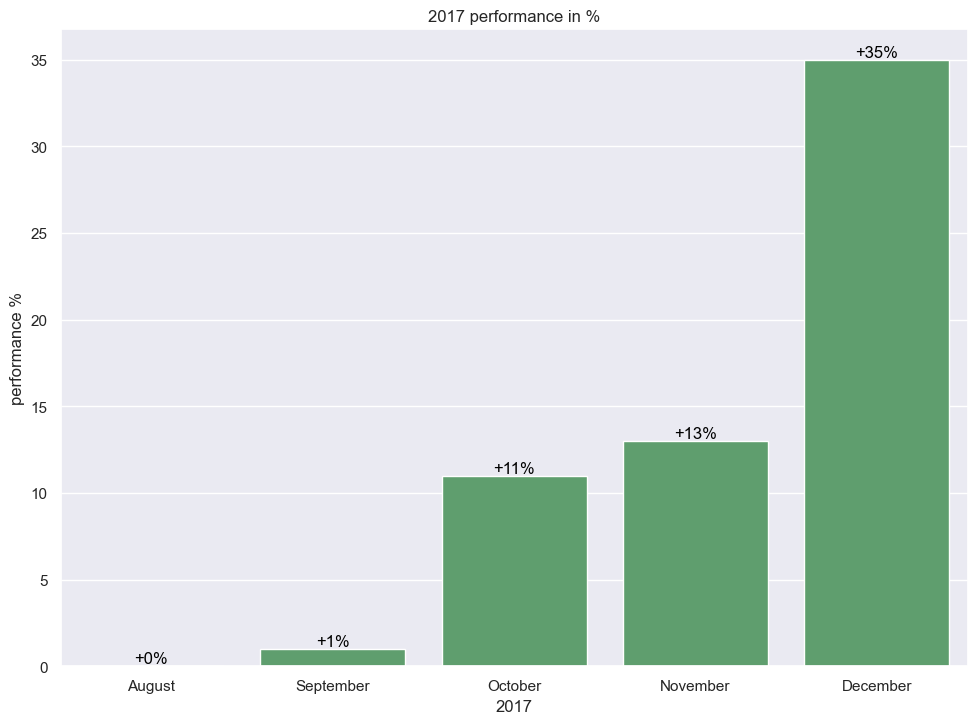

----- 2018 Cumulative Performances: 65.74%--


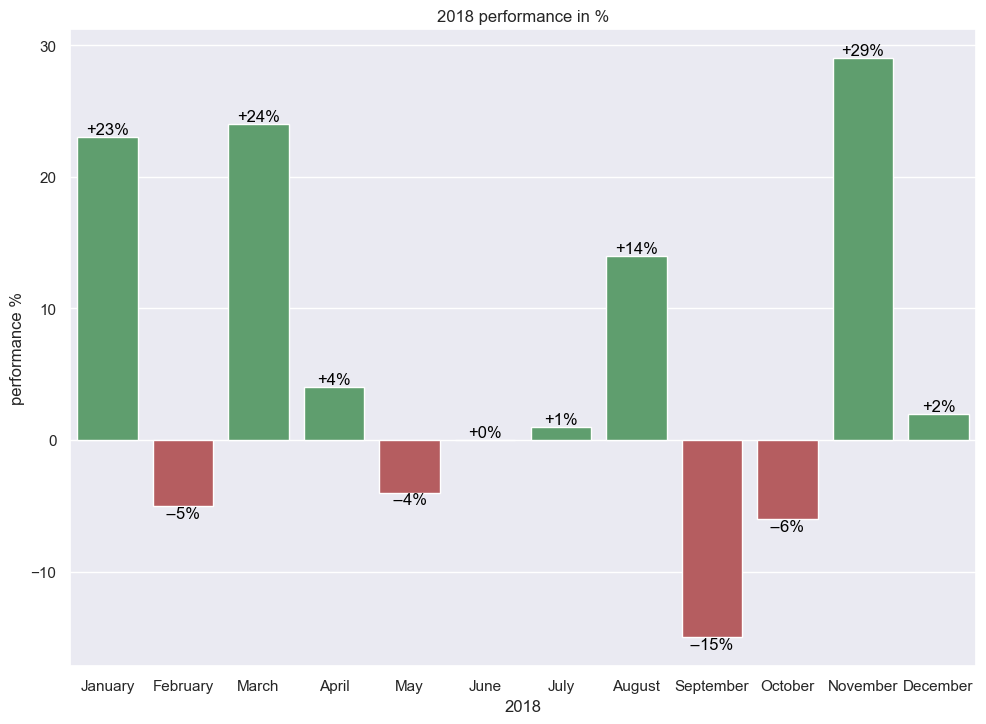

----- 2019 Cumulative Performances: 146.06%--


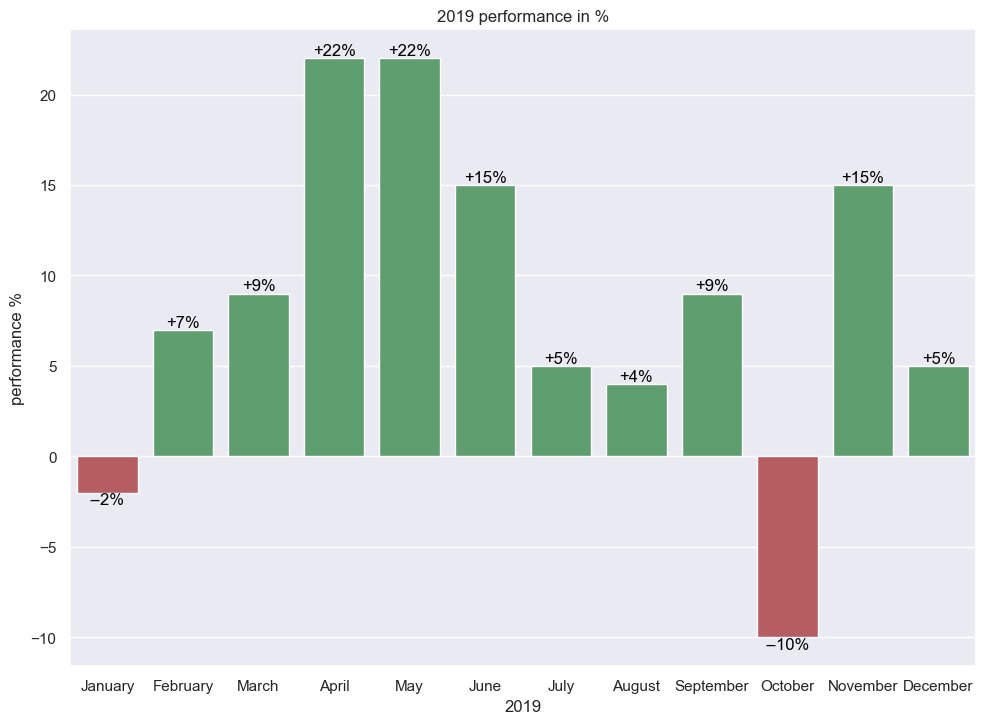

----- 2020 Cumulative Performances: 108.63%--


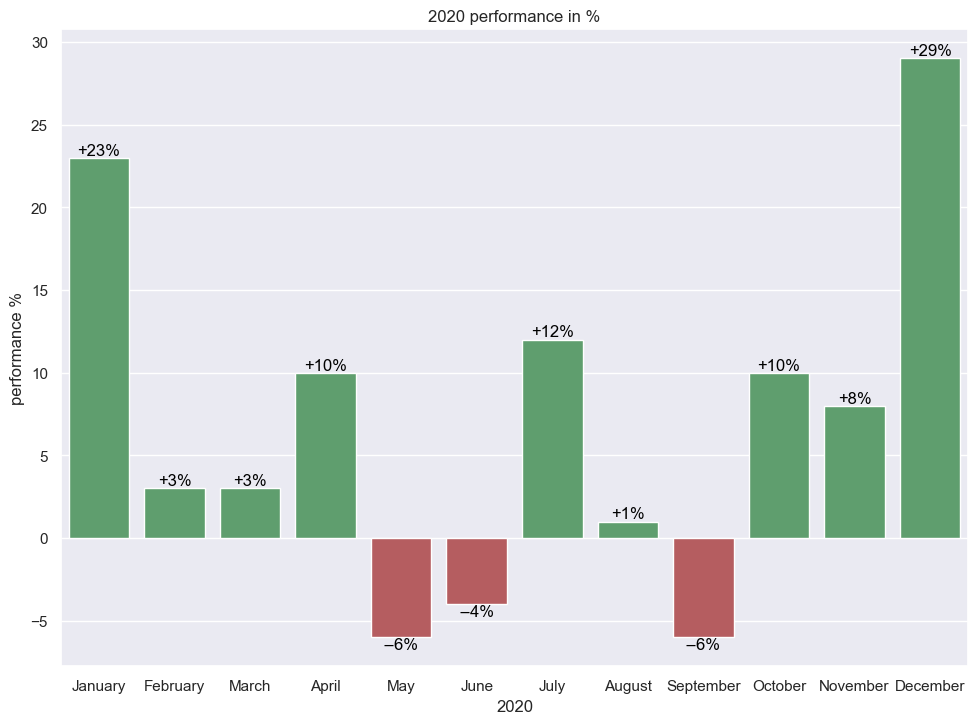

----- 2021 Cumulative Performances: 520.13%--


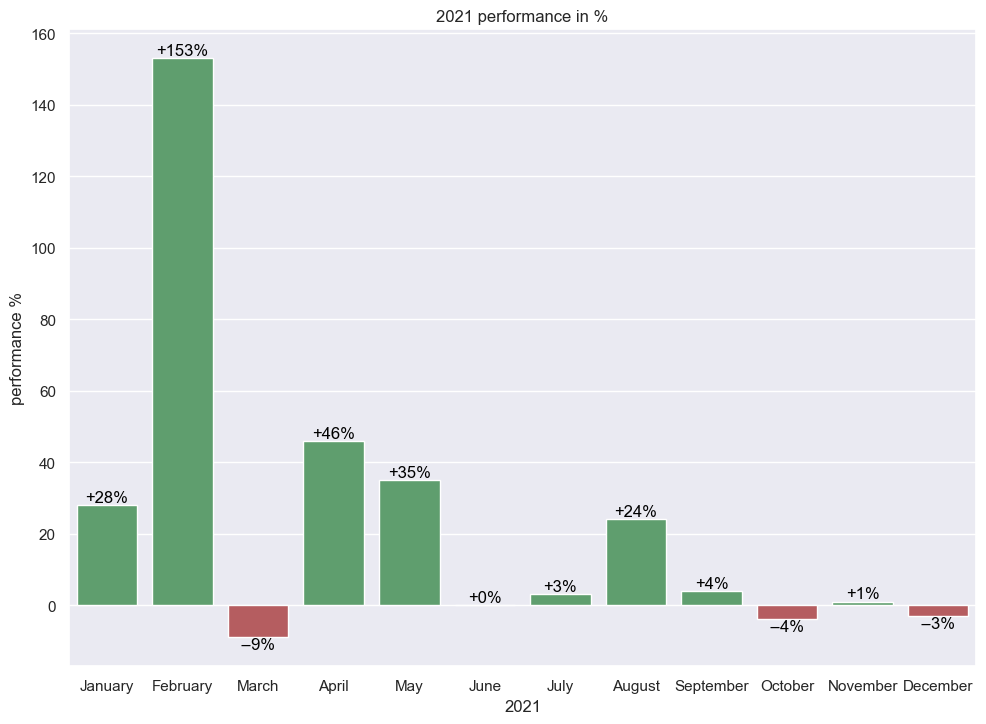

----- 2022 Cumulative Performances: 7.85%--


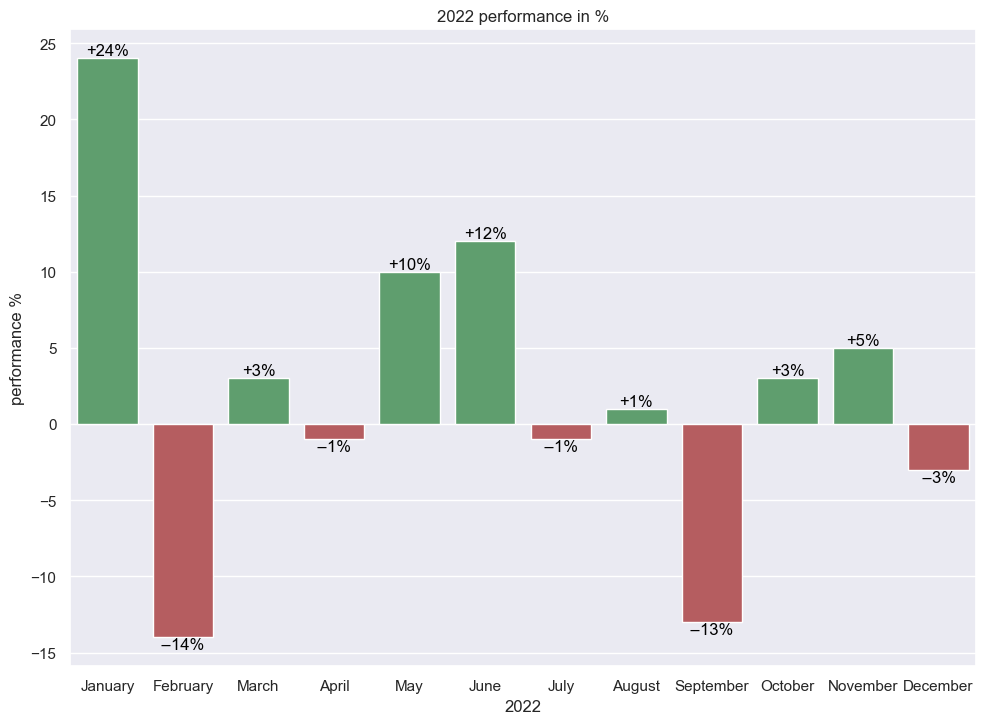

KeyError: '2023-1'

In [10]:
plot_bar_by_month(df_days=df_days)